In [2]:
# Initial imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import requests

%matplotlib inline

In [3]:
MSFT_csv = Path("../SaaS_Data/Microsoft_MSFT.csv")

In [4]:
MSFT_df = pd.read_csv(MSFT_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [5]:
MSFT_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-15,146.080002,147.880005,143.600006,145.039993,145.039993,4476900
2018-08-16,146.509995,146.910004,145.220001,145.729996,145.729996,3704000
2018-08-17,145.500000,146.009995,143.949997,145.020004,145.020004,2865600
2018-08-20,145.210007,146.059998,144.320007,145.710007,145.710007,2882200
2018-08-21,146.410004,148.789993,145.360001,145.529999,145.529999,4063700


In [6]:
MSFT_df.sort_index(ascending=True, inplace=True)

In [7]:
MSFT_df = MSFT_df.rename(columns={'Close': 'Close'})
MSFT_df = MSFT_df[['Close']]
MSFT_df

,Close
Date,
2018-08-15,145.039993
2018-08-16,145.729996
2018-08-17,145.020004
2018-08-20,145.710007
2018-08-21,145.529999
...,...
2021-08-09,249.320007
2021-08-10,243.389999
2021-08-11,242.279999


In [8]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window-1):
        features = df.iloc[i : (i+window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [9]:
window_size = 100
feature_column = 0
target_column = 0

X, y = window_data(MSFT_df, window_size, feature_column, target_column)

print(f"X sample values:\n{X[:3]} \n")
print(f"y sample values:\n{y[:3]}")

X sample values:
[[145.039993 145.729996 145.020004 145.710007 145.529999 146.460007
  147.830002 152.300003 151.679993 152.990005 154.800003 152.139999
  152.679993 153.210007 148.649994 148.830002 150.429993 151.320007
  152.839996 155.369995 158.179993 157.490005 154.919998 156.
  152.899994 155.5      155.520004 158.779999 158.869995 158.330002
  160.429993 159.029999 159.860001 157.259995 159.100006 154.899994
  155.070007 148.649994 148.5      137.809998 139.240005 146.740005
  141.949997 147.440002 147.009995 142.839996 140.490005 142.949997
  140.660004 133.259995 140.800003 135.520004 130.990005 132.169998
  137.240005 139.589996 136.789993 135.440002 133.949997 141.789993
  141.869995 136.919998 130.5      132.160004 129.350006 132.490005
  132.550003 121.010002 120.669998 123.589996 122.029999 126.410004
  127.540001 140.639999 139.720001 142.759995 144.149994 139.240005
  142.059998 135.949997 137.270004 136.789993 140.089996 141.139999
  137.039993 130.830002 132.320007 13

In [10]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [11]:
y_train

array([[145.990005],
       [147.039993],
       [147.550003],
       [146.050003],
       [149.190002],
       [148.539993],
       [149.820007],
       [152.509995],
       [148.949997],
       [149.75    ],
       [146.869995],
       [149.740005],
       [147.330002],
       [145.179993],
       [149.160004],
       [151.970001],
       [155.869995],
       [157.720001],
       [158.990005],
       [158.130005],
       [154.929993],
       [156.669998],
       [159.910004],
       [162.789993],
       [160.399994],
       [159.470001],
       [159.050003],
       [160.610001],
       [158.539993],
       [159.630005],
       [161.309998],
       [161.360001],
       [163.      ],
       [163.119995],
       [163.649994],
       [164.529999],
       [158.5     ],
       [156.970001],
       [156.789993],
       [155.600006],
       [155.059998],
       [157.649994],
       [158.279999],
       [159.809998],
       [160.669998],
       [161.509995],
       [161.949997],
       [163.9

In [12]:
# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [13]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [15]:
model = Sequential()

number_units = window_size
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape= (X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units = number_units,
    return_sequences = True
    ))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units = number_units
    ))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [17]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
4/4 [==============================] - 9s 520ms/step - loss: 0.0989
Epoch 2/20
4/4 [==============================] - 2s 531ms/step - loss: 0.0618
Epoch 3/20
4/4 [==============================] - 2s 624ms/step - loss: 0.0445
Epoch 4/20
4/4 [==============================] - 2s 674ms/step - loss: 0.0185
Epoch 5/20
4/4 [==============================] - 3s 775ms/step - loss: 0.0237
Epoch 6/20
4/4 [==============================] - 3s 765ms/step - loss: 0.0188
Epoch 7/20
4/4 [==============================] - 3s 766ms/step - loss: 0.0189
Epoch 8/20
4/4 [==============================] - 3s 815ms/step - loss: 0.0138
Epoch 9/20
4/4 [==============================] - 3s 789ms/step - loss: 0.0147
Epoch 10/20
4/4 [==============================] - 3s 778ms/step - loss: 0.0145
Epoch 11/20
4/4 [==============================] - 3s 763ms/step - loss: 0.0136
Epoch 12/20
4/4 [==============================] - 3s 833ms/step - loss: 0.0129
Epoch 13/20
4/4 [==============================] 

In [18]:
model.evaluate(X_test, y_test, verbose=0)

0.05048041790723801

In [19]:
predicted = model.predict(X_test)

In [20]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [21]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [22]:
MSFT_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = MSFT_df.index[-len(real_prices): ])

MSFT_actual_predicted.head()

,Actual,Predicted
Date,,
2020-07-31,191.699997,186.361374
2020-08-03,194.850006,186.181076
2020-08-04,203.190002,186.159210
2020-08-05,201.410004,186.507034
2020-08-06,202.639999,187.197449


In [23]:
MSFT_actual_predicted.tail()

,Actual,Predicted
Date,,
2021-08-09,250.589996,232.032532
2021-08-10,249.320007,232.331223
2021-08-11,243.389999,232.803986
2021-08-12,242.279999,233.261612
2021-08-13,248.389999,233.601944


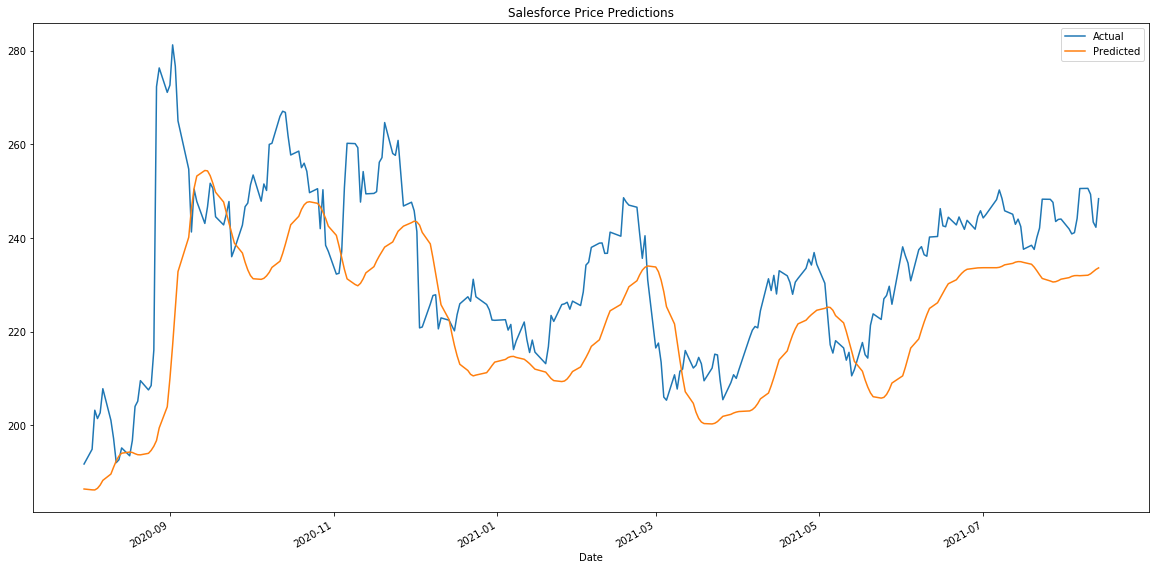

In [24]:
MSFT_actual_predicted.plot(figsize=(20,10), title="Microsoft Price Predictions")